# Mounting Google Drive

In [1]:
from google.colab import drive

drive.mount("/content/drive")       

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/RGB_5G - Combine.zip" -d "/content/dataset1/"  

Archive:  /content/drive/MyDrive/RGB_5G - Combine.zip
   creating: /content/dataset1/RGB_5G - Combine/16QAM/
  inflating: /content/dataset1/RGB_5G - Combine/16QAM/4QAM_RGB1.png  
  inflating: /content/dataset1/RGB_5G - Combine/16QAM/4QAM_RGB10.png  
  inflating: /content/dataset1/RGB_5G - Combine/16QAM/4QAM_RGB100.png  
  inflating: /content/dataset1/RGB_5G - Combine/16QAM/4QAM_RGB101.png  
  inflating: /content/dataset1/RGB_5G - Combine/16QAM/4QAM_RGB102.png  
  inflating: /content/dataset1/RGB_5G - Combine/16QAM/4QAM_RGB103.png  
  inflating: /content/dataset1/RGB_5G - Combine/16QAM/4QAM_RGB104.png  
  inflating: /content/dataset1/RGB_5G - Combine/16QAM/4QAM_RGB105.png  
  inflating: /content/dataset1/RGB_5G - Combine/16QAM/4QAM_RGB106.png  
  inflating: /content/dataset1/RGB_5G - Combine/16QAM/4QAM_RGB107.png  
  inflating: /content/dataset1/RGB_5G - Combine/16QAM/4QAM_RGB108.png  
  inflating: /content/dataset1/RGB_5G - Combine/16QAM/4QAM_RGB109.png  
  inflating: /content/dataset1

In [5]:
#/content/dataset1/RGB_5G - Combine
ROOT_FOLDER_PATH_DATASET = "/content/dataset1/"

DATA_DIR = ROOT_FOLDER_PATH_DATASET + "RGB_5G - Combine/";
IMAGES_FOLDER = ROOT_FOLDER_PATH_DATASET + "JPEGImages/";

TRAIN_DATA_X_FILE = ROOT_FOLDER_PATH_DATASET + "train-data-X.h5";
TRAIN_DATA_Y_FILE= ROOT_FOLDER_PATH_DATASET + "train-data-Y.h5";
TEST_DATA_X_FILE = ROOT_FOLDER_PATH_DATASET + "test-data-X.h5";
TEST_DATA_Y_FILE = ROOT_FOLDER_PATH_DATASET + "test-data-Y.h5";

TRAIN_PREPROCESSED_FILE = ROOT_FOLDER_PATH_DATASET + "train-processed-X.h5";
TEST_PREPROCESSED_FILE = ROOT_FOLDER_PATH_DATASET + "test-processed-X.h5";


MODEL_SAVE_PATH = ROOT_FOLDER_PATH_DATASET + "trained_resnet50_model";



batch_size = 32
IMG_HEIGHT = 100
IMG_WIDTH = 100


# Save h5 files functions

In [6]:
import h5py
def save_dataset(filename , data):
  h5f = h5py.File(filename, 'w')
  h5f.create_dataset('dataset_1', data=data);
  h5f.close();

def read_dataset(filename):
  with h5py.File(filename, 'r') as hf:
    data = hf['dataset_1'][:]
    return data;


# Load Data

In [7]:
import tensorflow as tf;
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.01,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.05,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT , IMG_WIDTH),
  batch_size=batch_size)



Found 2000 files belonging to 5 classes.
Using 1980 files for training.
Found 2000 files belonging to 5 classes.
Using 100 files for validation.


# Create Files containing data

In [13]:

import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input

from keras.utils import to_categorical

import numpy as np;
X_TRAIN_DATA = [];
Y_TRAIN_DATA = [];

X_TEST_DATA=  [];
Y_TEST_DATA = [];

plt.figure(figsize=(10, 10))

def vectorize(val):
  vector = np.zeros(20);
  vector[val] = 1;
  return vector;

for images, labels in train_ds.take(len(train_ds)):
  for i in range(len(images)):
    X_TRAIN_DATA.append(images[i].numpy().astype("uint8"));
    Y_TRAIN_DATA.append(to_categorical(int(labels[i]) , num_classes = 5, dtype ="uint8"));


X_TRAIN_DATA = np.array(X_TRAIN_DATA);
Y_TRAIN_DATA = np.array(Y_TRAIN_DATA);

print("done training images");




done training images


<Figure size 1000x1000 with 0 Axes>

In [14]:
for images, labels in val_ds.take(len(val_ds)):
  for i in range(len(images)):
    X_TEST_DATA.append(images[i].numpy().astype("uint8"));
    Y_TEST_DATA.append(to_categorical(int(labels[i]) , num_classes = 5, dtype ="uint8"));


X_TEST_DATA = np.array(X_TEST_DATA);
Y_TEST_DATA = np.array(Y_TEST_DATA);

print(X_TRAIN_DATA.shape , Y_TRAIN_DATA.shape)


(1980, 100, 100, 3) (1980, 5)


# Create H5 files

In [15]:
#SAVE TRAIN X DATA
save_dataset(TRAIN_DATA_X_FILE , X_TRAIN_DATA);
#SAVE TRAIN Y DATA
save_dataset(TRAIN_DATA_Y_FILE , Y_TRAIN_DATA);
#save test x data
save_dataset(TEST_DATA_X_FILE , X_TEST_DATA);
#save test y data
save_dataset(TEST_DATA_Y_FILE , Y_TEST_DATA);



# Load Test / Train Data

In [16]:
# READ FILES
TRAIN_X = read_dataset(TRAIN_DATA_X_FILE);
TRAIN_Y = read_dataset(TRAIN_DATA_Y_FILE);
TEST_X = read_dataset(TEST_DATA_X_FILE);
TEST_Y = read_dataset(TEST_DATA_Y_FILE);
print(TRAIN_X.shape,TRAIN_Y.shape , TEST_X.shape ,TEST_Y.shape );


(1980, 100, 100, 3) (1980, 5) (100, 100, 100, 3) (100, 5)


In [17]:

from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
TRAIN_X = np.array([preprocess_input(img) for img in TRAIN_X]);
TEST_X = np.array([preprocess_input(img) for img in TEST_X]);



In [21]:
# make model
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras import layers, models
import tensorflow as tf;

resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))



for layer in resnet50_model.layers:
    layer.trainable = False;


for layer in resnet50_model.layers[160:]:   
  layer.trainable = True;      


x = layers.Flatten()(resnet50_model.output)
x = layers.Dense(256, activation='relu')(x)

predictions = layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=resnet50_model.input, outputs=predictions)


In [22]:
model.summary()
print(len(resnet50_model.layers))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']       

# Training Model

In [23]:
#TRAINING DATA
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf;
from keras.optimizers import Adam
import numpy as np;

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.AUC(num_thresholds=100)],
)

print("compilation done")

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

# print(train_Data.shape , len(train_labels.shape));
# print(train_labels[20]);


history = model.fit(TRAIN_X , TRAIN_Y,  epochs=50 ,validation_split=0.2,  batch_size=32)
# model.fit(TRAIN_X , TRAIN_Y,  epochs=10 ,validation_data=(TEST_X , TEST_Y),  batch_size=32, callbacks=[es])

# history = model.fit(TRAIN_X , TRAIN_Y,  epochs=20 ,validation_split=0.2,  batch_size=32)


compilation done
Epoch 1/50
50/50 [==============================] - 18s 101ms/step - loss: 1.8257 - accuracy: 0.2955 - auc: 0.6456 - val_loss: 1.2902 - val_accuracy: 0.3788 - val_auc: 0.7693
Epoch 2/50
50/50 [==============================] - 3s 51ms/step - loss: 0.4446 - accuracy: 0.8832 - auc: 0.9857 - val_loss: 1.4793 - val_accuracy: 0.3737 - val_auc: 0.7546
Epoch 3/50
50/50 [==============================] - 3s 51ms/step - loss: 0.1265 - accuracy: 0.9842 - auc: 0.9997 - val_loss: 1.4137 - val_accuracy: 0.4167 - val_auc: 0.7785
Epoch 4/50
50/50 [==============================] - 2s 49ms/step - loss: 0.0298 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.4497 - val_accuracy: 0.4167 - val_auc: 0.7849
Epoch 5/50
50/50 [==============================] - 2s 49ms/step - loss: 0.0131 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.4679 - val_accuracy: 0.4318 - val_auc: 0.7862
Epoch 6/50
50/50 [==============================] - 2s 49ms/step - loss: 0.0077 - accuracy: 1.0000 - auc: 1.0000 - v

# Save model

In [24]:
model.save(MODEL_SAVE_PATH);


# Load Model

In [25]:
import tensorflow as tf;
model = tf.keras.models.load_model(MODEL_SAVE_PATH);

# Testing the model

In [26]:

import tensorflow as tf;
import numpy as np;
from sklearn.metrics import average_precision_score

preds = model.predict(TEST_X);
print(preds)
mean_ap = average_precision_score(TEST_Y, preds)    ## average precison score
print(mean_ap);

4/4 [==============================] - 2s 205ms/step
[[4.79225913e-04 1.42364562e-01 8.95881560e-04 1.90516368e-01
  6.65743947e-01]
 [1.83973301e-04 7.21294820e-01 9.47466033e-05 2.75488257e-01
  2.93818372e-03]
 [9.40254688e-01 1.08383624e-02 1.03311883e-02 3.84302475e-02
  1.45542552e-04]
 [1.84088749e-05 9.76505160e-01 4.28356492e-04 7.60682812e-03
  1.54412528e-02]
 [2.68278038e-03 7.96321332e-01 3.98672390e-04 4.63412181e-02
  1.54256061e-01]
 [6.91708326e-01 1.46097294e-03 3.02100152e-01 1.01267186e-03
  3.71782132e-03]
 [5.16977767e-03 4.81210612e-02 4.87559766e-01 4.57152933e-01
  1.99642265e-03]
 [7.84098268e-01 2.93333542e-05 2.89934105e-04 2.47771665e-03
  2.13104740e-01]
 [1.11399160e-03 4.71440583e-01 4.11984930e-03 5.09531319e-01
  1.37942219e-02]
 [1.78621049e-05 3.66969332e-02 4.89290760e-05 6.27910197e-01
  3.35325986e-01]
 [1.59840711e-04 1.49241641e-01 8.91392301e-06 1.07363231e-01
  7.43226349e-01]
 [2.57449142e-06 9.95714068e-01 6.21139179e-07 1.82518415e-04
  4.1

In [27]:
predicted_classes = np.argmax(preds, axis=1)
true_labels=np.argmax(TEST_Y,axis=1)
print(predicted_classes)
print(true_labels)

[4 1 0 1 1 0 2 0 3 3 4 1 3 2 2 1 2 1 4 3 4 0 4 0 4 0 0 3 1 4 4 4 4 4 4 0 3
 0 1 4 0 0 4 0 2 4 1 0 1 4 3 4 4 1 2 4 0 4 4 1 2 3 3 0 2 1 0 4 0 0 2 3 2 0
 3 4 1 0 0 4 3 0 4 3 2 1 2 0 3 2 0 4 2 2 1 3 1 4 3 4]
[1 4 0 3 1 2 2 4 3 4 1 1 3 2 2 4 0 3 4 3 3 2 4 3 4 0 2 3 4 3 4 4 1 3 1 0 1
 2 3 3 0 0 3 0 2 1 3 0 4 4 4 3 4 4 0 3 0 1 1 4 2 1 1 2 3 1 0 3 2 0 2 3 0 2
 3 1 4 2 0 4 4 0 4 3 2 4 0 0 3 0 0 4 2 0 3 1 1 0 3 3]


**CONFUSION MATRIX & Classification Score**

In [29]:
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

labels = ['4QAM', '8QAM', '16QAM', '32QAM', '64QAM']
report = classification_report(true_labels, predicted_classes, target_names=labels)
cmat = confusion_matrix(true_labels, predicted_classes)
acc = accuracy_score(true_labels, predicted_classes)
print(report) 
print(cmat)
print(acc)

              precision    recall  f1-score   support

        4QAM       0.58      0.67      0.62        21
        8QAM       0.24      0.25      0.24        16
       16QAM       0.53      0.50      0.52        16
       32QAM       0.56      0.36      0.44        25
       64QAM       0.36      0.45      0.40        22

    accuracy                           0.45       100
   macro avg       0.45      0.45      0.44       100
weighted avg       0.46      0.45      0.45       100

[[14  0  6  0  1]
 [ 0  4  0  4  8]
 [ 8  0  8  0  0]
 [ 1  5  1  9  9]
 [ 1  8  0  3 10]]
0.45


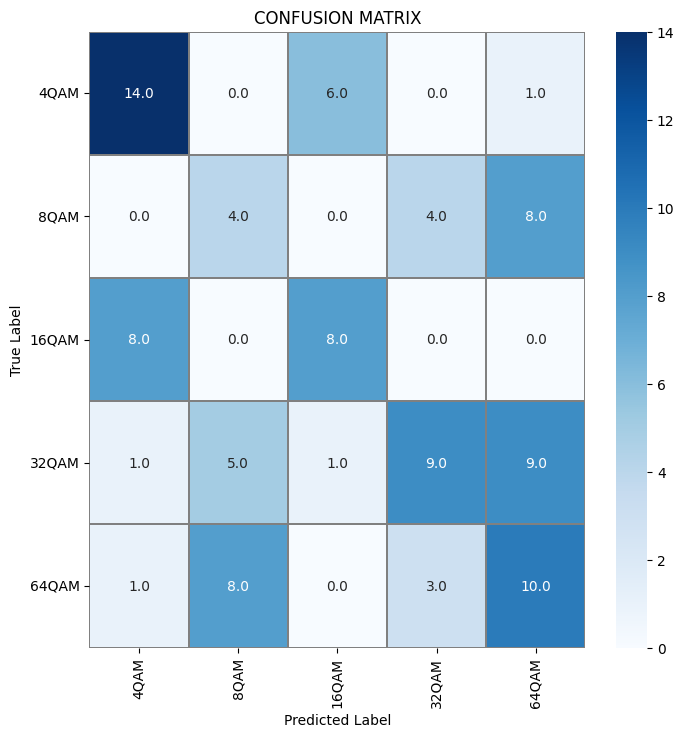

In [31]:
confusion_mtx = confusion_matrix(true_labels, predicted_classes)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Blues", linecolor="gray", fmt='.1f', ax=ax)

# Set labels and ticks
labels = ['4QAM', '8QAM', '16QAM', '32QAM', '64QAM']
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels, rotation=0)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.title("CONFUSION MATRIX")
plt.show()

# Mean Avg Precision wrt each class


In [32]:
import numpy as np
def calc_map(preds, targets):
   
    aps = []
    for i in range(targets.shape[1]):
        target = targets[:, i]
        pred = preds[:, i]
        sorted_idx = np.argsort(pred)[::-1]
        target = target[sorted_idx]
        tp = np.cumsum(target)
        fp = np.cumsum(1 - target)
        recall = tp / np.sum(target)
        precision = tp / (tp + fp)
        precision[np.isnan(precision)] = 0
        ap = np.sum(precision * np.diff(np.concatenate(([0], recall))))
        aps.append(ap)
    map_ = np.array(aps)
    return map_
map_scores_classes = calc_map(preds , TEST_Y)
print(map_scores_classes)
print(np.mean(map_scores_classes));  

[0.63117385 0.29034117 0.55357596 0.55604067 0.44548118]
0.49532256579534534


In [33]:
result = model.evaluate(TEST_X, TEST_Y);


4/4 [==============================] - 1s 38ms/step - loss: 1.9787 - accuracy: 0.4500 - auc: 0.7698


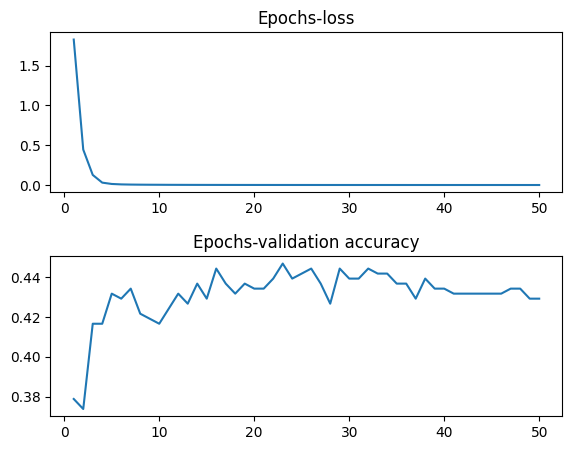

In [34]:

import matplotlib.pyplot as plt
%matplotlib inline

losses = history.history["loss"]
accuracies = history.history["accuracy"]
val_accuracies = history.history["val_accuracy"];

Xs = [i for i in range(1,len(losses)+1)];

plt.subplot(2, 1, 1)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.title("Epochs-loss")
plt.plot(Xs, losses)

plt.subplot(2, 1, 2)
plt.title("Epochs-validation accuracy")
plt.plot(Xs, val_accuracies)



